In [1]:
import json, json_repair, os, random
from pprint import pprint
from getpass import getpass
from typing import List, Dict
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.builders import PromptBuilder
from haystack.components.websearch.serper_dev import SerperDevWebSearch

from haystack.utils import Secret
from haystack import Pipeline, component

if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass("Enter your Groq API key: ")

if "SERPERDEV_API_KEY" not in os.environ:
    os.environ["SERPERDEV_API_KEY"] = getpass("Enter your SerperDev API key: ")

/Users/dazzpool/Documents/Github/autoQuizHaystack/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Quiz Generation Pipeline
 - We prompt Llama3 to generate a quiz within the format we provide it.
 - We create a custom `QuizParser` component to parse the output and create a JSON object that represents our quiz.

In [2]:
quiz_generation_template = """Given the following text, create 5 multiple choice quizzes in JSON format.
Each question should have 4 different options, and only one of them should be correct.
The options should be unambiguous.
Each option should begin with a letter followed by a period and a space (e.g., "a. option").
The question should also briefly mention the general topic of the text so that it can be understood in isolation.
Each question should not give hints to answer the other questions.
Include challenging questions, which require reasoning.

respond with JSON only, no markdown or descriptions.

example JSON format you should absolutely follow:
{"topic": "a sentence explaining the topic of the text",
 "questions":
  [
    {
      "question": "text of the question",
      "options": ["a. 1st option", "b. 2nd option", "c. 3rd option", "d. 4th option"],
      "right_option": "c"  # letter of the right option ("a" for the first, "b" for the second, etc.)
    }, ...
  ]
}

text:
{% for doc in documents %}{{ doc.content|truncate(4000) }}{% endfor %}
"""

# adding all of the required components to the pipeline
quiz_generation_pipeline = Pipeline()
quiz_generation_pipeline.add_component("link_content_fetcher", LinkContentFetcher())
quiz_generation_pipeline.add_component("html_converter", HTMLToDocument())
quiz_generation_pipeline.add_component("prompt_builder", PromptBuilder(template=quiz_generation_template))
quiz_generation_pipeline.add_component("generator",OpenAIGenerator(api_key=Secret.from_env_var("GROQ_API_KEY"),
                                                                   api_base_url="https://api.groq.com/openai/v1",
                                                                   model="llama3-8b-8192",
                                                                   generation_kwargs={"max_tokens": 1000, "temperature": 0.5, "top_p": 1},
                                                                  ))

# connecting the components in the pipeline
quiz_generation_pipeline.connect("link_content_fetcher", "html_converter")
quiz_generation_pipeline.connect("html_converter", "prompt_builder")
quiz_generation_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - link_content_fetcher: LinkContentFetcher
  - html_converter: HTMLToDocument
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - link_content_fetcher.streams -> html_converter.sources (List[ByteStream])
  - html_converter.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

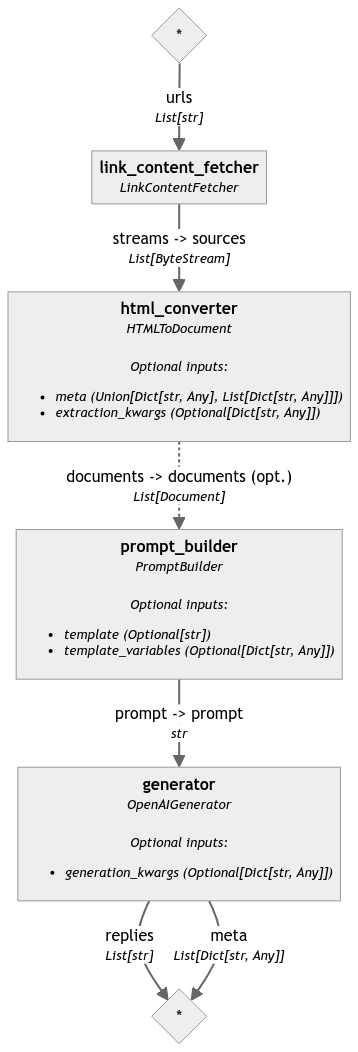

In [4]:
quiz_generation_pipeline.show()

In [5]:
quiz = quiz_generation_pipeline.run({"link_content_fetcher": {"urls": ['https://www.rainforest-alliance.org/species/capybara/']}})

In [6]:
print(quiz['generator']['replies'][0])

Here are 5 multiple choice quizzes in JSON format:

{
"topic": "Capybaras are the largest rodents on earth, and their physical characteristics and habits are described in this text.",
"questions":
[
{
"question": "What is the typical length of a capybara?",
"options": ["a. 2 feet", "b. 4 feet", "c. 1.2 meters", "d. 6 feet"],
"right_option": "b"
},
{
"question": "What is the primary threat to capybara populations?",
"options": ["a. Jaguars and caimans", "b. Deforestation", "c. Humans and farming", "d. Ocelots and harpy eagles"],
"right_option": "c"
},
{
"question": "What do capybaras eat to help digest their food?",
"options": ["a. Beneficial bacteria in their own poop", "b. Fiber from grass", "c. Grains and melons", "d. Fruits and vegetables"],
"right_option": "a"
},
{
"question": "Why do capybaras often spend their mornings resting?",
"options": ["a. They are nocturnal", "b. They are diurnal", "c. They need to conserve energy", "d. They are just lazy"],
"right_option": "c"
},
{
"quest

## The Quiz Parser

In [7]:
# to parse the quiz from the generated text (json format)
@component
class QuizParser:
    @component.output_types(quiz=Dict)
    def run(self, replies: List[str]):
        reply = replies[0]
        first_index = min(reply.find("{"), reply.find("["))
        last_index = max(reply.rfind("}"), reply.rfind("]")) + 1
        json_portion = reply[first_index:last_index]

        try:
            quiz = json.loads(json_portion)
        except json.JSONDecodeError:
            quiz = json_repair.loads(json_portion)
        if isinstance(quiz, list):
            quiz = quiz[0]
        return {"quiz": quiz}

In [8]:
parser = QuizParser()
parser.run(replies=quiz['generator']['replies'])

{'quiz': {'topic': 'Capybaras are the largest rodents on earth, and their physical characteristics and habits are described in this text.',
  'questions': [{'question': 'What is the typical length of a capybara?',
    'options': ['a. 2 feet', 'b. 4 feet', 'c. 1.2 meters', 'd. 6 feet'],
    'right_option': 'b'},
   {'question': 'What is the primary threat to capybara populations?',
    'options': ['a. Jaguars and caimans',
     'b. Deforestation',
     'c. Humans and farming',
     'd. Ocelots and harpy eagles'],
    'right_option': 'c'},
   {'question': 'What do capybaras eat to help digest their food?',
    'options': ['a. Beneficial bacteria in their own poop',
     'b. Fiber from grass',
     'c. Grains and melons',
     'd. Fruits and vegetables'],
    'right_option': 'a'},
   {'question': 'Why do capybaras often spend their mornings resting?',
    'options': ['a. They are nocturnal',
     'b. They are diurnal',
     'c. They need to conserve energy',
     'd. They are just lazy'],

In [9]:
quiz_generation_pipeline.add_component("parser", parser)
quiz_generation_pipeline.connect("generator", "parser")

🚅 Components
  - link_content_fetcher: LinkContentFetcher
  - html_converter: HTMLToDocument
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
  - parser: QuizParser
🛤️ Connections
  - link_content_fetcher.streams -> html_converter.sources (List[ByteStream])
  - html_converter.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)
  - generator.replies -> parser.replies (List[str])

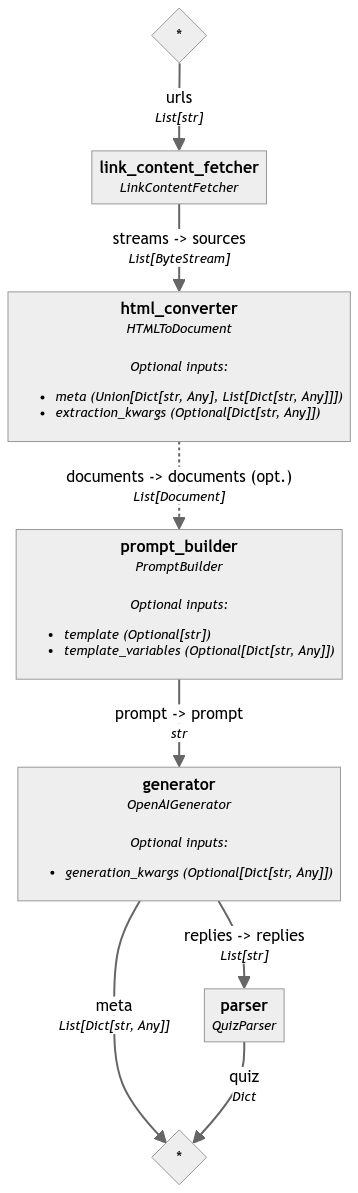

In [10]:
quiz_generation_pipeline.show()

In [11]:
result = quiz_generation_pipeline.run({"link_content_fetcher": {"urls": ["https://www.rainforest-alliance.org/species/capybara/"]}})

In [12]:
quiz = result['parser']['quiz']
pprint(quiz)

{'questions': [{'options': ['a. Less than 20 lbs',
                            'b. 20-50 lbs',
                            'c. More than 100 lbs',
                            'd. 50-80 lbs'],
                'question': 'What is the typical weight range of a capybara?',
                'right_option': 'c'},
               {'options': ['a. Africa',
                            'b. Asia',
                            'c. South America',
                            'd. North America'],
                'question': 'Where are capybaras most commonly found?',
                'right_option': 'c'},
               {'options': ['a. They are located on the sides of its head',
                            'b. They are located on the bottom of its head',
                            'c. They are located on the top of its head',
                            'd. They are located on the back of its head'],
                'question': "What is a distinctive feature of a capybara's "
                        

# 2. Closed Book Exam Pipeline
- In this pipeline, we will get Llama 3 8B Instruct to answer the quiz questions based on it's own knowledge and see how it does.

In [13]:
closed_book_template = """Answer the following question, specifying one of the options.
The topic is: {{ topic }}.

In the answer, just specify the letter corresponding to the option.
If you don't know the answer, just provide your best guess and do not provide any reasoning.

For example, if you think the answer is the first option, just write "a".
If you think the answer is the second option, just write "b", and so on.

question: {{ question["question"] }}
options: {{ question["options"] }}

chosen option (a, b, c, or d):
"""

closed_book_answer_pipeline = Pipeline()
closed_book_answer_pipeline.add_component(
    "prompt_builder", PromptBuilder(template=closed_book_template)
)
closed_book_answer_pipeline.add_component(
    "generator",
    OpenAIGenerator(
        api_key=Secret.from_env_var("GROQ_API_KEY"),
        api_base_url="https://api.groq.com/openai/v1",
        model="llama3-8b-8192",
        generation_kwargs={"max_tokens": 5, "temperature": 0, "top_p": 1},
    ),
)
closed_book_answer_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> generator.prompt (str)

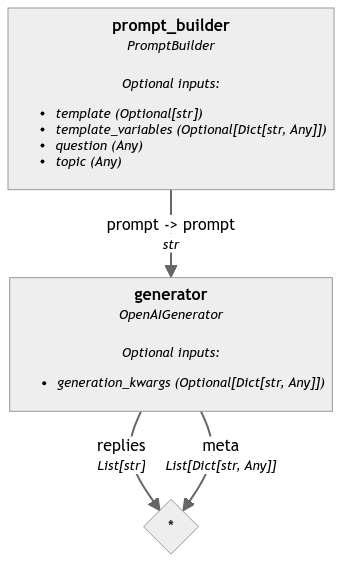

In [14]:
closed_book_answer_pipeline.show()

In [15]:
topic = quiz["topic"]
questions = quiz["questions"]

answers = []

for question in questions:
    answer = closed_book_answer_pipeline.run(
        {"prompt_builder": {"topic": topic, "question": question}}
    )["generator"]["replies"][0]

    if answer not in ["a", "b", "c", "d"]:
        answer = random.choice(["a", "b", "c", "d"])
    answers.append(answer)

In [16]:
answers

['b', 'c', 'a', 'c', 'c']

In [17]:
score = 0

for i, answer in enumerate(answers):
    right_option = quiz["questions"][i]["right_option"]
    if isinstance(answer, str) and answer == right_option:
        score += 1
        print("Correct answer: " + answer)
    else:
        print("Wrong. Correct answer: " + right_option)

score = score / 5

print("Final Score: " + str(score*100) + '%')

Wrong. Correct answer: c
Correct answer: c
Wrong. Correct answer: c
Correct answer: c
Correct answer: c
Final Score: 60.0%


# 3. Web RAG Exam Pipeline

In [18]:
web_rag_template = """Answer the question about "{{topic}}", using your knowledge and the snippets extracted from the web.

In the answer, just specify the letter corresponding to the option.
If you don't know the answer, just provide your best guess and do not provide any reasoning.

For example, if you think the answer is the first option, just write "a".
If you think the answer is the second option, just write "b", and so on.

question: {{ question["question"] }}
options: {{ question["options"] }}

Snippets:
{% for doc in documents %}
- snippet: "{{doc.content}}"
{% endfor %}

chosen option (a, b, c, or d):
"""

web_rag_pipeline = Pipeline()
web_rag_pipeline.add_component("websearch", SerperDevWebSearch(top_k=3))
web_rag_pipeline.add_component(
    "prompt_builder", PromptBuilder(template=web_rag_template)
)
web_rag_pipeline.add_component(
    "generator",
    OpenAIGenerator(
        api_key=Secret.from_env_var("GROQ_API_KEY"),
        api_base_url="https://api.groq.com/openai/v1",
        model="llama3-8b-8192",
        generation_kwargs={"max_tokens": 5, "temperature": 0, "top_p": 1},
    ),
)
web_rag_pipeline.connect("websearch.documents", "prompt_builder.documents")
web_rag_pipeline.connect("prompt_builder", "generator")

🚅 Components
  - websearch: SerperDevWebSearch
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - websearch.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

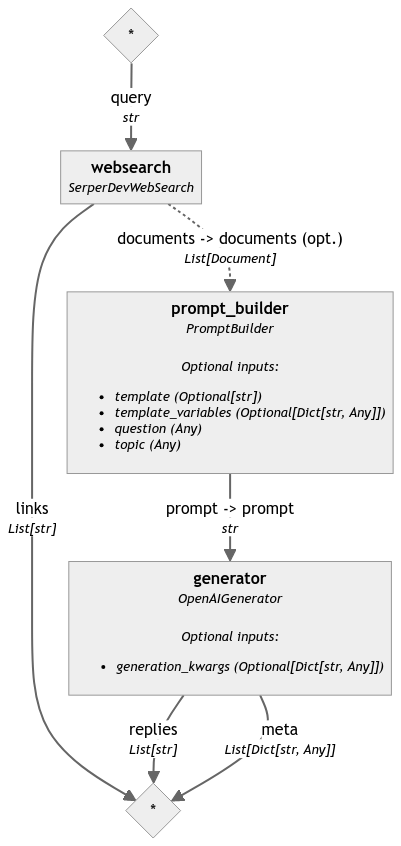

In [19]:
web_rag_pipeline.show()

In [20]:
web_rag_pipeline.draw('web_rag.png')